# Ice-Albedo Feedback

This notebook explores ice-albedo feedback using a grey gas and the functions in the document [```ice_albedo_feedback.py```](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/ice_albedo_feedback.py).

The basic idea behind ice-albedo feedback is that as temperature decreases, ice forms on the surface. This reflects solar short wave radiation more than land or sea and so the albedo increases. Hence the albedo of the grey gas is not a constant but depends on the surface temperature. 

We can include this relationship by supplying a [function rather than a number as the albedo](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/grey.py#L56-L58) to the grey gas. This function must take latitude and surface temperature as its first two arguments and must also have ```albedo_no_ice```, ```albedo_ice``` and ```T_ice``` as default arguments. ```T_ice``` is the temperature below which the albedo changes to ```albedo_ice```. In this notebook, we say that  ```T_ice = 263``` i.e. $-10^{\circ}C$ and we use the function [```albedo_step_function```](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/ice_albedo_feedback.py#L10-L34) which just says that any latitude where ```T_surface < T_ice``` have ```albedo = albedo_ice``` and all other latitudes have ```albedo = albedo_no_ice```.

To investigate this feedback, we need to change some parameter as to cause a change in surface temperature. We use the class [```GreyAlbedoFeedback```](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/ice_albedo_feedback.py#L37-L212) to do this. This allows us to change either the surface optical depth in the long wave band through ```tau_surface_values``` or the stellar constant through ```stellar_constant_values```. The value we want to change must be an array and the other must be a single value. 

At each value of the parameter we are changing, we initially establish the equilibrium temperature profile [in the absence of any albedo feedback](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/ice_albedo_feedback.py#L133-L136). We then see if any surface temperatures are below ```T_ice```, and if they are, we incrementally increase the albedo at these latitudes by ```delta_albedo``` and [find the new equilibrium temperature profile](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/ice_albedo_feedback.py#L138-L147) until the albedo reaches ```albedo_ice```.

## Changing surface optical depth
The below two cells, reduce ```tau_surface``` from 8 to 0.001 and then increase it from 0.001 to 8 again. This is equivalent to reducing and then increasing the amount of greenhouse gases. 

We use a simple [scale height atmospheric profile](https://github.com/jduffield65/ClimateModel/blob/b027c83921c61d247244f235ed2e8bd7cc642983/Model/radiation/grey_optical_depth.py#L30-L56) and neglect any interaction with short wave radiation.

In [2]:
from Model.radiation.ice_albedo_feedback import GreyAlbedoFeedback;
import Model.radiation.grey_optical_depth as od;
from Model.constants import p_surface, F_sun;
import numpy as np

# arguments to pass to GreyGas class
nz = 'auto'
ny = 30
tau_lw_func=od.scale_height
tau_lw_func_args=[0.22 * p_surface, 4]
tau_sw_func=None
tau_sw_func_args=None
grey_gas_args = (nz, ny, tau_lw_func, tau_lw_func_args, tau_sw_func, tau_sw_func_args)

# changing tau
tau_surface_values = np.concatenate((np.arange(0.001, 0.05, 0.005), np.arange(0.2, 8.2, 0.2)))
stellar_constant_values = F_sun
changing_tau_example = GreyAlbedoFeedback(tau_surface_values, stellar_constant_values, *grey_gas_args)

100%|██████████| 99/99 [01:21<00:00,  1.22it/s]


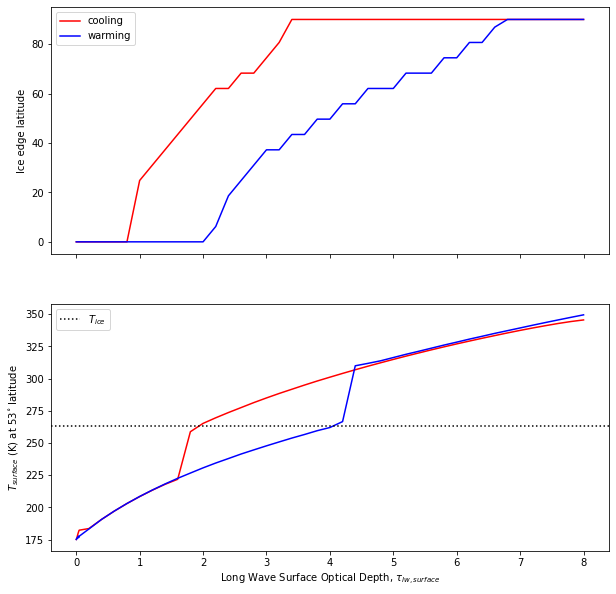

In [3]:
change_tau_data = {'albedo': [], 'ice_lat': [], 'T_surface': []}
change_tau_data['albedo'], change_tau_data['ice_lat'], change_tau_data['T_surface'] = changing_tau_example.run(
    delta_albedo = 0.3, delta_net_flux_thresh=0.1, conv_adjust=False)
changing_tau_example.plot(change_tau_data['ice_lat'], change_tau_data['T_surface'])

It can be seen that a hysteresis behaviour is exhibited. 

For large greenhouse gas concentrations, the ice edge latitude is $90^{\circ}$ meaning the planet is completely ice free (hothouse state). For very small greenhouse gas concentrations, the ice edge latitude is $0^{\circ}$, meaning the planet is completely ice covered (snowball state).

For in-between concentrations, the state depends on the history. For example, a planet coming out of a snowball state would remain a snowball if the greenhouse gas concentration was increased such that $\tau_{lw, surface} = 2$. On the other hand, a planet coming out of a hot house state would remain ice free for latitudes below around $50^{\circ}$ at $\tau_{lw, surface} = 2$ and would only become a snowball at $\tau_{lw, surface} \approx 0.9$

So once a planet gets into a snowball state, it is hard to get out of.

## Changing stellar constant

We can observe the same effect by changing the strength of the star through the stellar constant, $F^{\odot}$, which is the flux density at the surface of the planet in units of $Wm^{-2}$. The current solar value is $1367 Wm^{-2}$. This analysis is relevant to all planets because stars are fainter when they are younger.

For example, lets assume that for the planet below, $F^{\odot} = 400Wm^{-2}$ initially and in the main sequence stage, it reaches $750Wm^{-2}$. Then initially, the planet must be a snowball as it is the only equilibrium solution. Then as the star becomes more powerful, the planet remains a snowball, as the ice only disappears when $F^{\odot} \approx 800Wm^{-2}$. 


In [4]:
# changing stellar constant
tau_surface_values = 4
stellar_constant_values = np.arange(300, 2250, 50)
changing_stellar_example = GreyAlbedoFeedback(tau_surface_values, stellar_constant_values, *grey_gas_args)

100%|██████████| 77/77 [04:29<00:00,  3.50s/it]


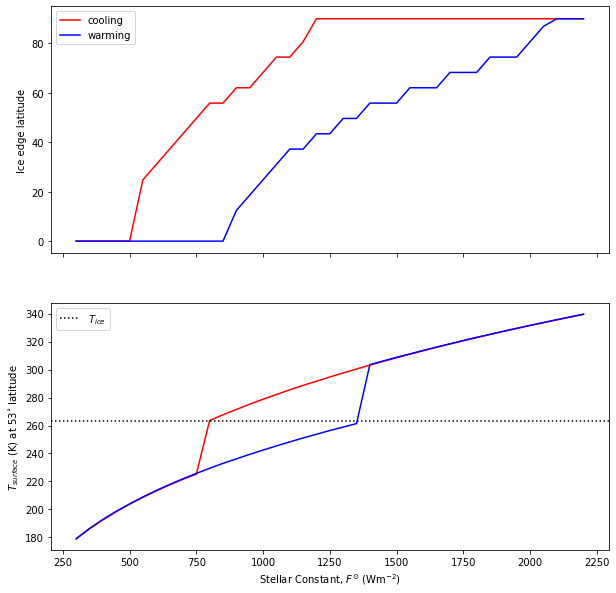

In [5]:
change_stellar_data = {'albedo': [], 'ice_lat': [], 'T_surface': []}
change_stellar_data['albedo'], change_stellar_data['ice_lat'], change_stellar_data['T_surface'] = changing_stellar_example.run(
    delta_albedo = 0.1, delta_net_flux_thresh=1e-3, conv_adjust=False)
changing_stellar_example.plot(change_stellar_data['ice_lat'], change_stellar_data['T_surface'])

## Faint Young Sun
For the Earth, the fact that it is not currently in a snowball state is known as the faint young sun paradox. The solution to it is that the atmospheric composition of the early Earth is thought to have a greater greenhouse effect, i.e. a larger $\tau_{lw, surface}$ than it does now.

For example, the below cell shows the same planet as the above cell but with $\tau_{lw, surface}$ increased from 4 to 5. You can see that now initially, when $F^{\odot} = 400Wm^{-2}$, the planet no longer has to be in a snowball state as there are two equilibrium solutions (There is still an equilibrium snowball state and the state that of the planet would depend on the even earlier history for this case). 

This illustrates the resolution to the faint young sun paradox although the numbers are wrong. For Earth, the initial stellar constant would be $960Wm^{-2}$ and the main sequence value would be $1367 Wm^{-2}$.

100%|██████████| 77/77 [07:00<00:00,  5.46s/it]


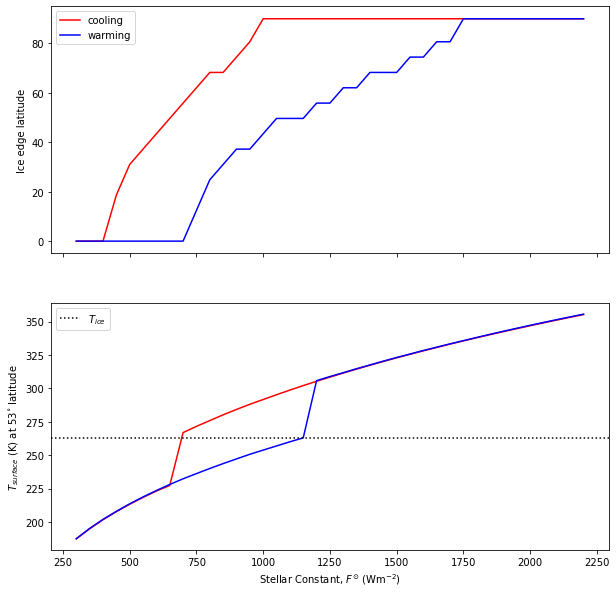

In [11]:
tau_lw_func_args[1] = 5
changing_stellar_example2 = GreyAlbedoFeedback(tau_surface_values, stellar_constant_values, *grey_gas_args)
change_stellar_data2 = {'albedo': [], 'ice_lat': [], 'T_surface': []}
change_stellar_data2['albedo'], change_stellar_data2['ice_lat'], change_stellar_data2['T_surface'] = changing_stellar_example2.run(
    delta_albedo = 0.1, delta_net_flux_thresh=1e-3, conv_adjust=False)
changing_stellar_example2.plot(change_stellar_data2['ice_lat'], change_stellar_data2['T_surface'])